In [71]:
# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np

# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)
eps = 0.1

# Set constants
pi = tf.constant(np.pi, dtype=DTYPE)
viscosity = .01/pi

# Define initial condition
# def fun_u_0(x):
#     return -tf.sin(pi * x)

# Define boundary condition
def fun_u_b(t, x):
    n = x.shape[0]
    return tf.zeros((n,1), dtype=DTYPE)

# Define residual of the PDE
def fun_r(x, u, u_x):
    # return eps*u_xx + 2 * u_x + 2*u
    return u_x - u*(1-u)

In [72]:
# Set number of data points
N_b = 2
N_r = 100

# Set boundary
xmin = 0.
xmax = 1.

# Lower bounds
lb = 0
# Upper bounds
ub = np.pi/2

# Set random seed for reproducible results
tf.random.set_seed(0)

# Draw uniform sample points for initial boundary data
# t_0 = tf.ones((N_0,1), dtype=DTYPE)*lb[0]
# x_0 = tf.random.uniform((N_0,1), lb[1], ub[1], dtype=DTYPE)
# X_0 = tf.concat([t_0, x_0], axis=1)

# Evaluate intitial condition at x_0
# u_0 = fun_u_0(x_0)

# Boundary data
# t_b = tf.random.uniform((N_b,1), lb[0], ub[0], dtype=DTYPE)
# x_b = lb[1] + (ub[1] - lb[1]) * tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype=DTYPE)
# X_b = tf.concat([t_b, x_b], axis=1)
# x_b = tf.constant([lb, ub], dtype=DTYPE)
x_b = tf.constant([lb], dtype=DTYPE)
X_b = x_b

# Evaluate boundary condition at (t_b,x_b)
# u_b = fun_u_b(t_b, x_b)
# u_b = tf.constant([0.0, 1.0])
u_b = tf.constant([0.5])

# Draw uniformly sampled collocation points
# t_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
x_r = tf.random.uniform((N_r,1), lb, ub, dtype=DTYPE)
# X_r = tf.concat([t_r, x_r], axis=1)
X_r = x_r

# Collect boundary and inital data in lists
X_data = [X_b]
u_data = [u_b]

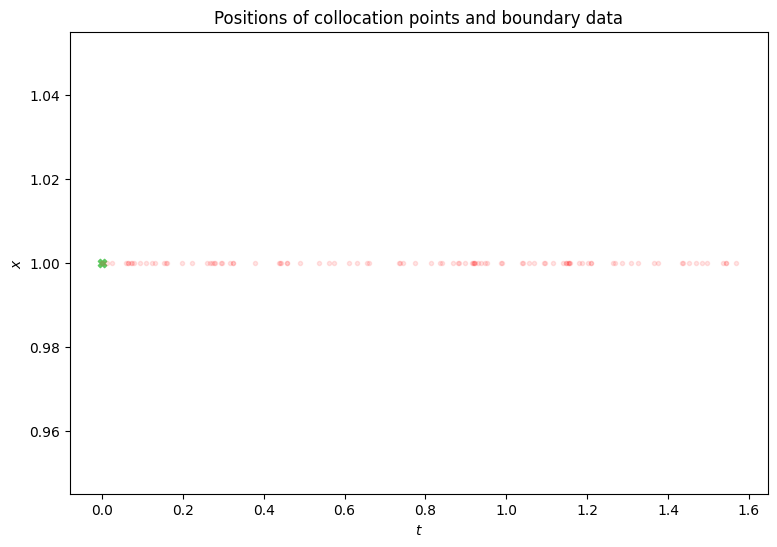

In [73]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9,6))
# plt.scatter(t_0, x_0, c=u_0, marker='X', vmin=-1, vmax=1)
plt.scatter(x_b, tf.ones((len(x_b),1)), c=u_b, marker='X', vmin=-1, vmax=1)
plt.scatter(x_r, tf.ones((len(x_r),1)), c='r', marker='.', alpha=0.1)
plt.xlabel('$t$')
plt.ylabel('$x$')

plt.title('Positions of collocation points and boundary data');
#plt.savefig('Xdata_Burgers.pdf', bbox_inches='tight', dpi=300)

In [74]:
def init_model(num_hidden_layers=8, num_neurons_per_layer=20):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    # Input is two-dimensional (time + one spatial dimension)
    model.add(tf.keras.Input(1))

    # Introduce a scaling layer to map input to [lb, ub]
    # scaling_layer = tf.keras.layers.Lambda(
    #             lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
    # model.add(scaling_layer)

    # Append hidden layers
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('tanh'),
            kernel_initializer='glorot_normal'))

    # Output is one-dimensional
    model.add(tf.keras.layers.Dense(1))
    
    return model

In [75]:
def get_r(model, X_r):
    
    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:
        # Split t and x to compute partial derivatives
        x = X_r[:, 0:1]

        # Variables t and x are watched during tape
        # to compute derivatives u_t and u_x
        # tape.watch(t)
        tape.watch(x)

        # Determine residual 
        # u = model(tf.stack([x[:,0]], axis=1))
        u = model(x)

        # Compute gradient u_x within the GradientTape
        # since we need second derivatives
    u_x = tape.gradient(u, x)
            
    # u_t = tape.gradient(u, t)
    # u_xx = tape.gradient(u_x, x)

    del tape

    return fun_r(x, u, u_x)

In [76]:
def compute_loss(model, X_r, X_data, u_data):
    
    # Compute phi^r
    r = get_r(model, X_r)
    phi_r = tf.reduce_mean(tf.square(r))
    
    # Initialize loss
    loss = phi_r
    
    # Add phi^0 and phi^b to the loss
    for i in range(len(X_data)):
        u_pred = model(X_data[i])
        loss += tf.reduce_mean(tf.square(u_data[i] - u_pred))
    
    return loss

In [77]:
def get_grad(model, X_r, X_data, u_data):
    
    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, X_r, X_data, u_data)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g

In [78]:
# Initialize model aka u_\theta
model = init_model()

# We choose a piecewise decay of the learning rate, i.e., the
# step size in the gradient descent type algorithm
# the first 1000 steps use a learning rate of 0.01
# from 1000 - 3000: learning rate = 0.001
# from 3000 onwards: learning rate = 0.0005

# lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])
lr = 0.1

# Choose the optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr)

In [79]:
from time import time

# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step():
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad(model, X_r, X_data, u_data)
    
    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))
    
    return loss, grad_theta

# Number of training epochs
N = 5000
hist = []

# Start timer
t0 = time()

for i in range(N+1):
    
    loss, grad = train_step()
    
    # Append current loss to hist
    hist.append(loss.numpy())
    
    # Output current loss after 50 iterates
    if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))
        
# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 2.92080313e-01
It 00050: loss = 6.28361925e-02
It 00100: loss = 6.25121742e-02
It 00150: loss = 6.24928512e-02
It 00200: loss = 6.24904297e-02
It 00250: loss = 6.24858774e-02
It 00300: loss = 6.24739788e-02
It 00350: loss = 6.23989031e-02
It 00400: loss = 6.64265677e-02
It 00450: loss = 6.87138587e-02
It 00500: loss = 6.25269115e-02
It 00550: loss = 6.25000596e-02
It 00600: loss = 6.25000000e-02
It 00650: loss = 6.25000000e-02
It 00700: loss = 6.25000000e-02
It 00750: loss = 6.25000000e-02
It 00800: loss = 6.25000000e-02
It 00850: loss = 6.25000000e-02
It 00900: loss = 6.25000000e-02
It 00950: loss = 6.25000000e-02
It 01000: loss = 6.25000000e-02
It 01050: loss = 6.25000000e-02
It 01100: loss = 6.25000000e-02
It 01150: loss = 6.25000000e-02
It 01200: loss = 6.25000000e-02
It 01250: loss = 6.25000000e-02
It 01300: loss = 6.25000000e-02
It 01350: loss = 6.25000000e-02
It 01400: loss = 6.25000000e-02
It 01450: loss = 6.25000000e-02
It 01500: loss = 6.25000000e-02
It 01550

Text(0, 0.5, '$\\phi_{n_{epoch}}$')

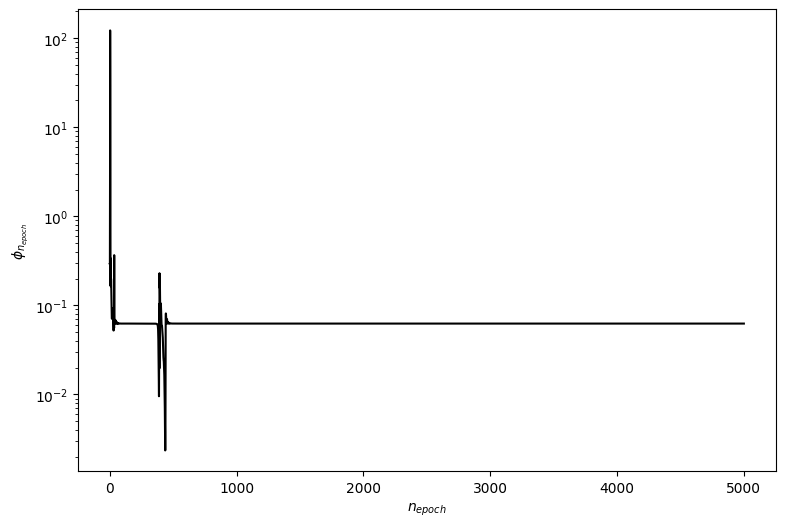

In [80]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(hist)), hist,'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$')

In [81]:
from mpl_toolkits.mplot3d import Axes3D

# Set up meshgrid
# N = 600
# tspace = np.linspace(lb[0], ub[0], N + 1)
# xspace = np.linspace(lb[1], ub[1], N + 1)
# T, X = np.meshgrid(tspace, xspace)
# Xgrid = np.vstack([T.flatten(),X.flatten()]).T

N = 100
xspace = np.linspace(0,1,N)

# Determine predictions of u(t, x)
upred = model(tf.cast(xspace,DTYPE))

# Reshape upred
# U = upred.numpy().reshape(N+1,N+1)

# Surface plot of solution u(t,x)
# fig = plt.figure(figsize=(9,6))
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(T, X, U, cmap='viridis');
# ax.view_init(35,35)
# ax.set_xlabel('$t$')
# ax.set_ylabel('$x$')
# ax.set_zlabel('$u_\\theta(t,x)$')
# ax.set_title('Solution of Burgers equation');
#plt.savefig('Burgers_Solution.pdf', bbox_inches='tight', dpi=300);

In [82]:
upred

<tf.Tensor: shape=(100, 1), dtype=float32, numpy=
array([[0.49999928],
       [0.4999994 ],
       [0.49999928],
       [0.4999992 ],
       [0.49999925],
       [0.49999928],
       [0.49999925],
       [0.49999934],
       [0.4999992 ],
       [0.4999993 ],
       [0.49999928],
       [0.4999992 ],
       [0.4999993 ],
       [0.49999928],
       [0.49999925],
       [0.49999937],
       [0.49999928],
       [0.4999994 ],
       [0.4999992 ],
       [0.49999928],
       [0.49999928],
       [0.49999937],
       [0.4999993 ],
       [0.4999994 ],
       [0.49999934],
       [0.49999928],
       [0.4999993 ],
       [0.4999993 ],
       [0.4999994 ],
       [0.49999937],
       [0.49999917],
       [0.49999934],
       [0.4999994 ],
       [0.4999992 ],
       [0.49999928],
       [0.49999925],
       [0.49999928],
       [0.4999994 ],
       [0.49999937],
       [0.4999993 ],
       [0.4999993 ],
       [0.49999928],
       [0.49999923],
       [0.49999934],
       [0.49999928],
     